# Data Generation

In [19]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

dim_theta = 10
data_num = 1000
scale = .1

theta_true = np.ones((dim_theta,1))
print('True theta:', theta_true.reshape(-1))

A = np.random.uniform(low=-1.0, high=1.0, size=(data_num,dim_theta))
y_data = A @ theta_true + np.random.normal(loc=0.0, scale=scale, size=(data_num, 1))

A_test = np.random.uniform(low=-1.0, high=1.0, size=(50, dim_theta))
# print(A_test)
y_test = A_test @ theta_true + np.random.normal(loc=0.0, scale=scale, size=(50, 1))

True theta: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Solving for the exact mean squared loss (solving Ax = b)

In [20]:
'''
Hints:
1. See the least squares solution to Ax = b (when it is covered in lecture).

2. Use Numpy functions like Numpy's linear algebra functions to solve for x in Ax = b.
In fact, the linear algebra module is already imported with ```import numpy.linalg as la```.

3. Use the defined variable A in Ax = b. Use y_data as b. Use theta_pred as x.
'''
inverse = la.inv((A.T).dot(A))
theta_pred = inverse.dot((A.T).dot(y_data))

# theta_pred = NotImplemented # TODO: Implement the analytical solution

print('Empirical theta', theta_pred.reshape(-1))

Empirical theta [0.99550861 1.00319253 1.0000844  1.00992802 0.99743074 1.00283825
 0.99058402 0.99563209 1.00302007 1.00547237]


# SGD Variants Noisy Function

In [21]:
batch_size = 1
max_iter = 1000
lr = 0.001
theta_init = np.random.random((10,1)) * 0.1

In [22]:
def noisy_val_grad(theta_hat, data_, label_, deg_=2.):
    gradient = np.zeros_like(theta_hat)
    loss = 0
    
    for i in range(data_.shape[0]):
        x_ = data_[i, :].reshape(-1,1)
        y_ = label_[i, 0]
        err = np.sum(x_ * theta_hat) - y_
        
        grad = deg_*np.abs(err)**(deg_ -1.)*np.sign(err)*x_ 
        l = np.abs(err)**deg_ 
        
        loss += l / data_.shape[0]
        gradient += grad / data_.shape[0]
        
    return loss, gradient

# data_ = A
# deg_ = 2.
# label_ = y_data
# gradient = np.zeros_like(theta_init)
# loss = 0

# for i in range(data_.shape[0]):
#     x_ = data_[i, :].reshape(-1,1)
#     y_ = label_[i, 0]
#     err = np.sum(x_ * theta_init) - y_
    
#     grad = deg_*(np.abs(err)**(deg_ - 1.))*np.sign(err)*x_
#     l = np.abs(err)**deg_
    
#     loss += l / data_.shape[0]
#     gradient += grad / data_.shape[0]
    
    
# print(gradient)
# print(loss)




# Running SGD Variants

adam 0
[0.29652043 0.3480524  0.30550605 0.37600208 0.24950829 0.34408513
 0.29131439 0.30953596 0.3551552  0.30043863]
adam done
sgd 0
[0.4821684  0.46688272 0.48755309 0.56273958 0.49583671 0.51731789
 0.46752957 0.4137007  0.52124573 0.36785824]
sgd done


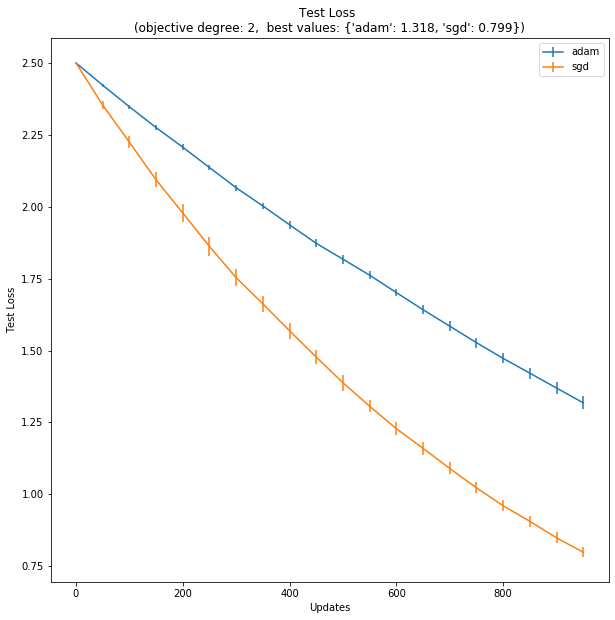

In [25]:
#@title Parameters
deg_ = 2 #@param {type: "number"}
num_rep = 15 #@param {type: "integer"}
max_iter = 1000 #@param {type: "integer"}
fig, ax = plt.subplots(figsize=(10,10))
best_vals = {}
test_exp_interval = 50 #@param {type: "integer"}
grad_artificial_normal_noise_scale = 0. #@param {type: "number"}

for method_idx, method in enumerate(['adam', 'sgd']): #, 'adagrad']):
    test_loss_mat = []
    train_loss_mat = []
    
    for replicate in range(num_rep):
        if replicate % 20 == 0:
            print(method, replicate)
            
        if method == 'adam':
            beta_1 = 0.9
            beta_2 = 0.999
            m = 0 
            v = 0 
            epsilon = 1e-8 #NotImplemented

#         if method == 'adagrad':
#             print('Adagrad Not implemented.')
#             epsilon = NotImplemented # TODO: Initialize parameters
#             squared_sum = NotImplemented
            
        theta_hat = theta_init.copy()
        test_loss_list = []
        train_loss_list = []

        for t in range(max_iter):
            idx = np.random.choice(data_num, batch_size) # Split data
            train_loss, gradient = noisy_val_grad(theta_hat, A[idx,:], y_data[idx,:], deg_=deg_)
            artificial_grad_noise = np.random.randn(10, 1) * grad_artificial_normal_noise_scale + np.sign(np.random.random((10, 1)) - 0.5) * 0.
            gradient = gradient + artificial_grad_noise
            train_loss_list.append(train_loss)
            
            if t % test_exp_interval == 0:
                test_loss, _ = noisy_val_grad(theta_hat, A_test[:,:], y_test[:,:], deg_=deg_)
                test_loss_list.append(test_loss)                
            
            if method == 'adam':
               
                m =  beta_1*m + (1-beta_1)*gradient
                v =  beta_2*v + (1-beta_2)*np.square(gradient)
                m_hat = m/(1-(beta_1**(t+1)))
                v_hat = v/(1-(beta_2**(t+1)))
                tmp = np.sqrt(v_hat) + epsilon
                theta_hat = theta_hat - lr*np.divide(m_hat,tmp)
            

            elif method == 'sgd':
                theta_hat = theta_hat - lr * gradient
        
        test_loss_mat.append(test_loss_list)
        train_loss_mat.append(train_loss_list)
    
    print(theta_hat.flatten())
    print(method, 'done')

    x_axis = np.arange(max_iter)[::test_exp_interval]
    test_loss_np = np.array(test_loss_mat)
    
    
    test_loss_mean = np.mean(test_loss_np,axis=0)
    test_loss_se = np.std(test_loss_np,axis=0)/np.sqrt(num_rep)

    plt.errorbar(x_axis, test_loss_mean, yerr=2.5*test_loss_se, label=method)
    best_vals[method] = min(test_loss_mean)
    best_vals = { k: int(v * 1000) / 1000. for k,v in best_vals.items() }

plt.title(f'Test Loss \n(objective degree: {deg_},  best values: {best_vals})')
plt.ylabel('Test Loss')
plt.legend()
plt.xlabel('Updates')
plt.savefig('gamma-5.pdf')